# Using the TensorFlow Estimator APIs

In this lab, we'll explore using TensorFlow's high-level [`tf.estimator`](https://www.tensorflow.org/programmers_guide/estimators) APIs, in order to easily build, train, evaluate, and use NN models.

We'll do this via both the 'MNIST' dataset, and [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png), which is a direct drop-in replacement for the original MNIST dataset.
(You can read more about it, and why it was created, [here](https://github.com/zalandoresearch/fashion-mnist). It is a more challenging dataset than 'regular' MNIST, which has become too easy these days.)

The lab starts with a [`LinearClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier), then uses a [`DNNClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier) with multiple hidden layers.

As part of the lab, we'll explore what [TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard) can do.



**If you're running this notebook on colab**, download the dataset.py file from the repo:

In [1]:
%%bash
wget https://raw.githubusercontent.com/amygdala/tensorflow-workshop/master/workshop_sections/high_level_APIs/dataset.py
ls -l dataset.py

-rw-r--r-- 1 root root 4347 Aug 17 19:11 dataset.py


--2018-08-17 19:11:35--  https://raw.githubusercontent.com/amygdala/tensorflow-workshop/master/workshop_sections/high_level_APIs/dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4347 (4.2K) [text/plain]
Saving to: ‘dataset.py’

     0K ....                                                  100% 71.3M=0s

2018-08-17 19:11:35 (71.3 MB/s) - ‘dataset.py’ saved [4347/4347]



Do some imports and check your version of TensorFlow.  It must be >=1.4, and ideally >=1.7.

In [2]:
from __future__ import absolute_import, division, print_function
import numpy as np
import os
import time

import tensorflow as tf
import dataset

print(tf.__version__)

# define a utility function for generating a new directory in which to save 
# model information, so multiple training runs don't stomp on each other.
def get_new_path(name=""):
    base = os.path.abspath("/tmp/tfmodels/mnist_estimators")
    logpath = os.path.join(base, name + "_" + str(int(time.time())))
    print("Logging to {}".format(logpath))
    return logpath

1.10.0


## Getting started: A Linear Classifier

First, let's build a LinearClassifier. 

We'll first build the models' input functions.

We'll use [Datasets](https://www.tensorflow.org/get_started/datasets_quickstart) to manage the input to our model. The [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) module contains a collection of classes that allows you to easily load data, manipulate it, and pipe it into your model. 
[Datasets support highly scalable and performant input pipelines](https://www.tensorflow.org/performance/datasets_performance), and it is best practice to use them where possible.


In [0]:
DATA_DIR = "/tmp/MNIST_data"
NUM_STEPS = 5000
BATCH_SIZE = 100

def train_input_fn(data_dir, batch_size=100):
  """Prepare data for training."""

  # When choosing shuffle buffer sizes, larger sizes result in better
  # randomness, while smaller sizes use less memory. MNIST is a small
  # enough dataset that we can easily shuffle the full epoch.
  ds = dataset.train(data_dir)
  ds = ds.cache().shuffle(buffer_size=50000).batch(batch_size=batch_size)

  # Iterate through the dataset a set number of times
  # during each training session.
  ds = ds.repeat(40)
  features = ds.make_one_shot_iterator().get_next()
  return {'pixels': features[0]}, features[1]


def eval_input_fn(data_dir, batch_size=100):
  features = dataset.test(data_dir).batch(
      batch_size=batch_size).make_one_shot_iterator().get_next()
  return {'pixels': features[0]}, features[1]

Now, we'll define and train the LinearClassifier model.
Note that we didn't need to explicitly define a model graph or a training loop ourselves.


In [4]:
feature_columns = [tf.feature_column.numeric_column(
    "pixels", shape=784)]

linear_classifier = tf.estimator.LinearClassifier(
        feature_columns=feature_columns, 
        n_classes=10,
        model_dir=get_new_path("linear")
    )

train_input = lambda: train_input_fn(
    DATA_DIR,
    batch_size=BATCH_SIZE
)
linear_classifier.train(input_fn=train_input, steps=NUM_STEPS)

Logging to /tmp/tfmodels/mnist_estimators/linear_1534533340
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1a4a4a0cd0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tfmodels/mnist_estimators/linear_1534533340', '_train_distribute': None, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_

Once we've trained the model, we'll run the evaluate() method, which uses the trained model. To do this, it loads the most recent checkpointed model info available. The model checkpoint(s) are generated during the training process.


In [5]:
# Evaluate
eval_input = lambda: eval_input_fn(
    DATA_DIR,
    batch_size=BATCH_SIZE
)
results = linear_classifier.evaluate(input_fn=eval_input)
print(results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-17-19:16:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tfmodels/mnist_estimators/linear_1534533340/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-08-17-19:16:27
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.9291, average_loss = 0.26726565, global_step = 5000, loss = 26.726564
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tfmodels/mnist_estimators/linear_1534533340/model.ckpt-5000
{'average_loss': 0.26726565, 'accuracy': 0.9291, 'global_step': 5000, 'loss': 26.726564}


(Note that the model accuracy is not great... we'll get back to that).

We can also use the model to make a few predictions.   
Note: If you wanted to actually deploy and serve the model, in order to support scalable predictions, you'd want to export it in a specific `SavedModel` format.  We'll get to that in a later example.

In [6]:
# predictions

def predict_input_fn():
  features = dataset.test(DATA_DIR).take(5).batch(batch_size=1).make_one_shot_iterator().get_next()
  return {'pixels': features[0]}, features[1]

predictions = linear_classifier.predict(input_fn=predict_input_fn)

for prediction in predictions:
    print("Predictions:    {} with probabilities {}\n".format(
        prediction["classes"], prediction["probabilities"]))  


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tfmodels/mnist_estimators/linear_1534533340/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Predictions:    ['7'] with probabilities [3.0591463e-07 1.0422642e-13 1.2444417e-06 3.0422709e-03 6.7160741e-08
 1.0907888e-05 8.7714992e-12 9.9676764e-01 9.1745251e-06 1.6835738e-04]

Predictions:    ['2'] with probabilities [4.7198613e-05 7.5383684e-07 9.9194664e-01 1.4328808e-04 4.0119395e-17
 2.6218526e-03 5.2268622e-03 1.2350450e-21 1.3528743e-05 4.4825275e-17]

Predictions:    ['1'] with probabilities [1.9050948e-07 9.8389971e-01 9.9343723e-03 1.3205970e-03 6.6517117e-05
 7.1012176e-04 5.7844806e-04 5.0967117e-04 2.8752431e-03 1.0504787e-04]

Predictions:    ['0'] with probabilities [9.9992871e-01 1.4602835e-12 2.4637824e-05 8.2680185e-07 8.0468592e-09
 7.3336664e-06 3.2577092e-05 8.23

label: [7]
label: [2]
label: [1]
label: [0]
label: [4]


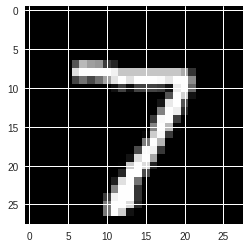

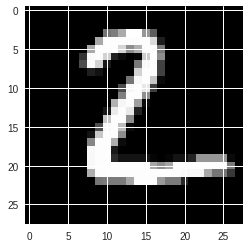

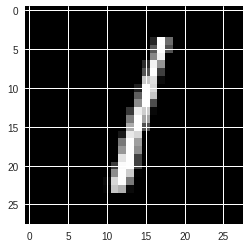

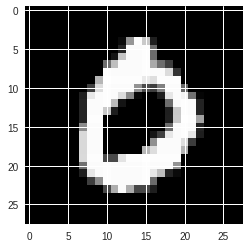

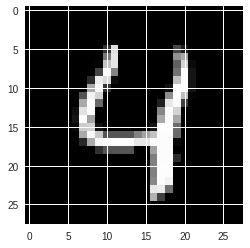

In [7]:
# Bonus: What are the labels for these predictions?
# This will fail if matplotlib is not installed. You can just skip it if so.

import matplotlib.pyplot as plt
%matplotlib inline

pred_next_item = dataset.test(DATA_DIR).take(5).batch(batch_size=1).make_one_shot_iterator().get_next()
sess =  tf.Session()
while True:
  try:
    item = sess.run(pred_next_item)
    pred_label = item[1]
    pred_image = item[0]
    print("label: %s" % pred_label)
    sample = np.reshape(pred_image, (28,28))
    plt.figure()
    plt.imshow(sample, 'gray')
  except tf.errors.OutOfRangeError:
    break

## DNNClassifier: try a Deep Neural Net on the same task

Next, let's see if a Deep Neural Net, with multiple hidden layers, does better at classification of these images.
We'll use a [`DNNClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier) with multiple hidden layers.

First, do some imports and set some variables:

In [0]:
DATA_DIR = "/tmp/MNIST_data"
NUM_STEPS = 15000
BATCH_SIZE = 100

Next, we'll define a `DNNClassifier`, and run its `train()` method, which will train the model. Again note that we didn't need to explicitly define a model graph or a training loop ourselves. 

You'll notice that this code looks much the same as that above, aside from a couple additional parameters when defining the model.
We can use the same train and eval input functions as above.


First, let's try training the DNNClassifier with a .1 learning rate.

In [9]:
feature_columns = [tf.feature_column.numeric_column(
    "pixels", shape=784)]

LR = .1

dnn_classifier = tf.estimator.DNNClassifier(
        feature_columns=feature_columns,
        n_classes=10,
        hidden_units=[128, 32], #hidden layer, now 2 layers, relu is default
        optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LR),
        model_dir=get_new_path("dnn")
    )

dnn_classifier.train(input_fn=train_input, steps=NUM_STEPS)

Logging to /tmp/tfmodels/mnist_estimators/dnn_1534533492
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1a227bb510>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tfmodels/mnist_estimators/dnn_1534533492', '_train_distribute': None, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_o

Now we'll evaluate the trained model. Note the accuracy.

In [10]:
# Evaluate

results = dnn_classifier.evaluate(input_fn=eval_input)
print(results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-17-19:19:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tfmodels/mnist_estimators/dnn_1534533492/model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-08-17-19:19:47
INFO:tensorflow:Saving dict for global step 15000: accuracy = 0.9764, average_loss = 0.1165063, global_step = 15000, loss = 11.65063
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: /tmp/tfmodels/mnist_estimators/dnn_1534533492/model.ckpt-15000
{'average_loss': 0.1165063, 'accuracy': 0.9764, 'global_step': 15000, 'loss': 11.65063}


Next, let's try using a .5 learning rate.

Worse results with bigger adjustment to weights (adjusted during back prop). Model is having trouble adjusting.

In [11]:
LR5 = .5

dnn_classifier5 = tf.estimator.DNNClassifier(
        feature_columns=feature_columns,
        n_classes=10,
        hidden_units=[128, 32],
        optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LR5),
        model_dir=get_new_path("dnn5")
    )

dnn_classifier5.train(input_fn=train_input, steps=NUM_STEPS)

Logging to /tmp/tfmodels/mnist_estimators/dnn5_1534533640
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1a1f511050>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tfmodels/mnist_estimators/dnn5_1534533640', '_train_distribute': None, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init

In [12]:
# Evaluate
results = dnn_classifier5.evaluate(input_fn=eval_input)
print(results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-17-19:23:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tfmodels/mnist_estimators/dnn5_1534533640/model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-08-17-19:23:09
INFO:tensorflow:Saving dict for global step 15000: accuracy = 0.1135, average_loss = 2.3012064, global_step = 15000, loss = 230.12065
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: /tmp/tfmodels/mnist_estimators/dnn5_1534533640/model.ckpt-15000
{'average_loss': 2.3012064, 'accuracy': 0.1135, 'global_step': 15000, 'loss': 230.12065}


<hr>
To compare your results, let's start up TensorBoard! 

**Note**: If you're running this notebook on **colab, you will not be able to run TensorBoard from the notebook**, so you will need to skip this step.

You can start it as follows in a new terminal window. (If you get a 'not found' error, make sure you've activated your virtual environment in that new window):

```sh
$ tensorboard --logdir=/tmp/tfmodels/mnist_estimators
```
Look for it at localhost:6006

Alternately, run the following (select Kernel --> Interrupt from the menu when you're done).

In [13]:
!tensorboard --logdir=/tmp/tfmodels/mnist_estimators

W0817 19:23:41.483645 Reloader plugin_event_accumulator.py:286] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0817 19:23:41.483644 139999811757824 plugin_event_accumulator.py:286] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0817 19:23:41.484552 Reloader plugin_event_accumulator.py:294] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
W0817 19:23:41.484551 139999811757824 plugin_event_accumulator.py:294] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
TensorBoard 1.10.0 at http://92b1be5c360d:6006 (Press CTRL+C to quit)
W0817 19:23:41.720101 Reloader plugin_event_accumulator.py:286] Found more than one graph event per run, or there was a metagr

## Fashion MNIST! and `tf.estimator.train_and_evaluate()`

Next, let's look at our results with a data set that's harder: [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist#get-the-data).

<img src="https://storage.googleapis.com/amy-jo/images/fashion-mnist-sprite%20_sm.png" width="40%"
         alt="Fashion MNIST">

If you haven't already downloaded the Fashion-MNIST files, you can do so as follows. **If you've already downloaded them, you don't need to do so again.**

In [0]:
%%bash
mkdir -p fashion_mnist
cd fashion_mnist
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
gunzip *
cd ..

If wget is not installed on your machine, try **replacing** the `wget` lines with:
```
curl -o train-images-idx3-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
curl -o train-labels-idx1-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
curl -o t10k-images-idx3-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
curl -o t10k-labels-idx1-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
```
or [download directly from the site](https://github.com/zalandoresearch/fashion-mnist#get-the-data).

Confirm that everything looks okay. You want the files to be **unzipped**.

In [0]:
%%bash
ls -l fashion_mnist

### `tf.estimator.train_and_evaluate()`

TensorFlow’s version 1.4 release [introduced](https://cloud.google.com/blog/big-data/2018/02/easy-distributed-training-with-tensorflow-using-tfestimatortrain-and-evaluate-on-cloud-ml-engine) the [`tf.estimator.train_and_evaluate`](https://www.tensorflow.org/api_docs/python/tf/estimator/train_and_evaluate) function, which simplifies training, evaluation, and exporting of Estimator models. It abstracts away the details of distributed execution for training and evaluation, while also supporting consistent behavior across local/non-distributed and distributed configurations.

For this example, we'll use `tf.estimator.train_and_evaluate` instead of making separate 'train' and 'evaluate' calls.
To keep this example simple, we're not including model export.
We'll show that in a later lab.

In [14]:
# edit path to directory as necessary
FASHION_DATA_DIR = "fashion_mnist" 

train_input_fashion = lambda: train_input_fn(
    FASHION_DATA_DIR,
    batch_size=BATCH_SIZE
)
eval_input_fashion = lambda: eval_input_fn(
    FASHION_DATA_DIR,
    batch_size=BATCH_SIZE
)

feature_columns = [tf.feature_column.numeric_column(
    "pixels", shape=784)]

LR = .1

run_config = tf.estimator.RunConfig()
run_config = run_config.replace(model_dir=get_new_path("fashion_dnn"))

fashion_dnn_classifier = tf.estimator.DNNClassifier(
        feature_columns=feature_columns,
        n_classes=10,
        hidden_units=[128, 32],
        optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LR),
        config=run_config
    )

train_spec = tf.estimator.TrainSpec(train_input_fashion,
                                  max_steps=NUM_STEPS
                                  )

# While not shown here, we can also add a model 'exporter' to the EvalSpec.
eval_spec = tf.estimator.EvalSpec(eval_input_fashion,
                                steps=NUM_STEPS,
                                name='fashion-eval'
                                )


Logging to /tmp/tfmodels/mnist_estimators/fashion_dnn_1534533961
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1a1d5a3610>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tfmodels/mnist_estimators/fashion_dnn_1534533961', '_train_distribute': None, '_save_summary_steps': 100}


Add another metric to the estimator -- *recall* -- using Tensorflow's built-in metrics.

In [0]:
def my_recall(labels, predictions):
  return {'recall': tf.metrics.recall(labels, predictions['class_ids'])}

In [16]:
# add the recall metric to the estimator
fashion_dnn_classifier = tf.contrib.estimator.add_metrics(fashion_dnn_classifier, my_recall)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1a1d5a3490>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tfmodels/mnist_estimators/fashion_dnn_1534533961', '_global_id_in_cluster': 0, '_save_summary_steps': 100}


## Exercise

Before running `train_and_evaluate`, try adding a *precision* metric too.

In [0]:
# your new code here

In [17]:
tf.estimator.train_and_evaluate(fashion_dnn_classifier,
                                train_spec,
                                eval_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tfmodels/mnist_estimators/fashion_dnn_1534533961/model.ckpt.
INFO:tensorflow:loss = 242.63501, step = 1
INFO:tensorflow:global_step/sec: 58.898
INFO:tensorflow:loss = 32.802177, step = 101 (1.702 sec)
INFO:tensorflow:global_step/sec: 359.996
INFO:tensorflow:loss = 22.262096, step = 201 (0.275 sec)
INFO:tensorflow:global_step/sec: 360.821
INFO:

({'accuracy': 0.9717,
  'average_loss': 0.12119035,
  'global_step': 15000,
  'loss': 12.119035,
  'recall': 0.997561},
 [])

You can see that the accuracy is significantly worse than with 'regular' MNIST. This dataset is harder! 


We can again make some predictions using our trained model:

In [18]:
# predictions

def predict_input_fn():
  features = dataset.test(FASHION_DATA_DIR).skip(5575).take(5).batch(batch_size=1).make_one_shot_iterator().get_next()
  return {'pixels': features[0]}, features[1]

predictions = fashion_dnn_classifier.predict(input_fn=predict_input_fn)

for prediction in predictions:
    print("Predictions:    {} with probabilities {}\n".format(
        prediction["classes"], prediction["probabilities"]))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tfmodels/mnist_estimators/fashion_dnn_1534533961/model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Predictions:    ['9'] with probabilities [1.1235951e-11 4.6678330e-12 2.2534880e-11 2.0967983e-08 2.1024067e-10
 2.0915565e-13 6.1805591e-20 6.6776922e-09 2.4371696e-10 1.0000000e+00]

Predictions:    ['7'] with probabilities [1.1016747e-13 5.0261326e-15 5.6939733e-08 1.9198199e-11 3.3126205e-21
 6.0149989e-19 1.7769626e-30 1.0000000e+00 1.1208151e-14 3.2354339e-09]

Predictions:    ['4'] with probabilities [8.1624996e-10 4.7270603e-07 9.5392846e-11 2.8148083e-12 9.9997663e-01
 4.1929996e-18 9.0256801e-13 1.5892836e-07 2.1653687e-14 2.2750701e-05]

Predictions:    ['8'] with probabilities [5.3714581e-07 2.8001807e

label: [9]
label: [7]
label: [4]
label: [8]
label: [5]


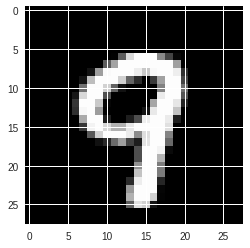

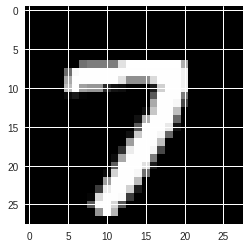

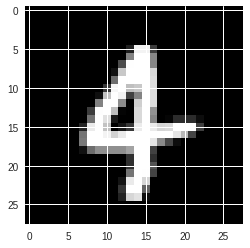

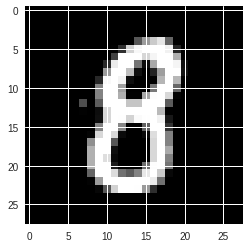

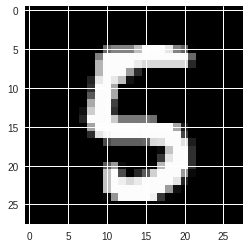

In [19]:
# Bonus: What are the labels for these predictions?
# This will fail if matplotlib is not installed. You can just skip it if so.

import matplotlib.pyplot as plt
%matplotlib inline

pred_next_item = dataset.test(FASHION_DATA_DIR).skip(5575).take(5).batch(batch_size=1).make_one_shot_iterator().get_next()
sess =  tf.Session()
while True:
  try:
    item = sess.run(pred_next_item)
    pred_label = item[1]
    pred_image = item[0]
    print("label: %s" % pred_label)
    sample = np.reshape(pred_image, (28,28))
    plt.figure()
    plt.imshow(sample, 'gray')
  except tf.errors.OutOfRangeError:
    break  

<hr>
Let's compare results again using TensorBoard.

**Note**: If you're running this notebook on **colab**, you will not be able to run TensorBoard from the notebook, so you will need to skip this step.

If TensorBoard is still running in a terminal window from before, it should pick up the new data automatically, since we pointed it to the parent directory of all the training runs we're doing. (If it doesn't seem to have done so, just reload).

Otherwise, start up TensorBoard as follows in a new terminal window. (If you get a 'not found' error, make sure you've activated your virtual environment in that new window):

```sh
$ tensorboard --logdir=/tmp/tfmodels/mnist_estimators
```
Look for it at localhost:6006

Or run the following (select Kernel --> Interrupt from the menu when you're done):

In [0]:
!tensorboard --logdir=/tmp/tfmodels/mnist_estimators

## Exercise

Try training a DNNClassifier model, using Fashion MNIST, with a .5 learning rate. 
Does this training do better or worse than the .1 learning rate on the Fashion MNIST dataset?

In [20]:
LR5 = .5
# Your edits here
fashion_dnn_classifier5 = ...

...

tf.estimator.train_and_evaluate(fashion_dnn_classifier5,
                                train_spec,
                                eval_spec)

SyntaxError: ignored

Did this training run do better or worse than the .1 learning rate on fashion mnist?

Copyright 2018 Google Inc. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
